In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Defined functions
# NA check
def findnanrows(df):
    is_NaN = df.isnull() 
    row_has_NaN = is_NaN.any(axis=1) 
    rows_with_NaN = df[row_has_NaN] 
    return rows_with_NaN

# missing 
def interpolatedata(df):
    filldf = df.groupby(pd.Grouper(freq='10T')).mean()
    dfnan = findnanrows(filldf)
    print("==> %s rows have been filled <==" %len(dfnan))
    filldf = filldf.interpolate().round(2)
    return filldf

# load data
def loaddata(sartyear, endyear):
    urlpath = 'https://www.bgc-jena.mpg.de/wetter/'
    urllist = []
    df = pd.DataFrame()
    for year in np.arange(sartyear, endyear, 1):
        urllist.append(urlpath+"mpi_roof_"+str(year)+"a.zip")
        urllist.append(urlpath+"mpi_roof_"+str(year)+"b.zip")
    for url in urllist:
        df = df.append(pd.read_csv(url, encoding='unicode_escape', parse_dates=True, index_col="Date Time"))
    df.index.name = 'datetime'
    return df

#ACF
def cal_ACF(y, lag, sample_plot_name):
    mean = np.mean(y)
    D = sum((y-mean)**2)
    R = []
    for tao in range(lag+1):
        S = 0
        for t in range(tao, len(y)):
            N = (y[t]-mean)*(y[t-tao]-mean)
            S += N
        r = S/D
        R.append(r)
    R_inv = R[::-1]
    Magnitute = R_inv + R[1:]
    ax = plt.figure()
    x_values = range(-lag, lag + 1)
    (markers, stemlines, baseline) = plt.stem(x_values, Magnitute, markerfmt='o')
    plt.setp(markers, color = 'red')
    m = 1.96/np.sqrt(len(y))
    plt.axhspan(-m, m, alpha = 0.2, color = 'blue')
    plt.xlabel('Lags')
    plt.ylabel('Magnitute')
    plt.title(f'Autocorrelation Function of {sample_plot_name}' )
    plt.show()
    return ax

In [20]:
raw_data = loaddata(sartyear=2019, endyear=2021)

/var/folders/fq/s6_sst4x3cv_zj9lkplg7f640000gn/T/ipykernel_45941/1813278560.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(url, encoding='unicode_escape', parse_dates=True, index_col="Date Time"))
/var/folders/fq/s6_sst4x3cv_zj9lkplg7f640000gn/T/ipykernel_45941/1813278560.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(url, encoding='unicode_escape', parse_dates=True, index_col="Date Time"))
/var/folders/fq/s6_sst4x3cv_zj9lkplg7f640000gn/T/ipykernel_45941/1813278560.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(url, encoding='unicode_escape', parse_dates=True, index_col="Date Time"))
/var/folders/fq/s6_sst4x3cv_zj9lkplg7f64000

In [21]:
#raw_data = pd.read_csv("raw_dataset.csv")

In [22]:
# raw dataset 
print(f"Shape of raw dataset: {raw_data.shape}")
print(f"NA in the raw dataset: {findnanrows(raw_data)}")
# save the raw dataset 
raw_data.to_csv("raw_dataset.csv")

Shape of raw dataset: (105256, 21)
NA in the raw dataset: Empty DataFrame
Columns: [p (mbar), T (degC), Tpot (K), Tdew (degC), rh (%), VPmax (mbar), VPact (mbar), VPdef (mbar), sh (g/kg), H2OC (mmol/mol), rho (g/m**3), wv (m/s), max. wv (m/s), wd (deg), rain (mm), raining (s), SWDR (W/m²), PAR (µmol/m²/s), max. PAR (µmol/m²/s), Tlog (degC), CO2 (ppm)]
Index: []

[0 rows x 21 columns]


In [23]:
# Missing observations
df = interpolatedata(raw_data)
#print(df.shape)

==> 9 rows have been filled <==


In [25]:
#change date format, remove index
date_range = pd.date_range(start="2019-01-01 00:10:00", end="2021-01-01 00:00:00", freq="10T")
df.insert(0, "date", date_range)
df = df.reset_index()
df = df.iloc[:, 1:]
df = df.set_index('date')
hourly_df = df.resample("60T").mean()
print(f"Hourly_df shape {hourly_df.shape}")

Hourly_df shape (17545, 21)


In [26]:
# Target varibale statistics
hourly_df["wv (m/s)"].describe()

count    17545.000000
mean         2.042032
std         12.676319
min      -1664.906667
25%          1.015000
50%          1.750000
75%          2.795000
max         13.215000
Name: wv (m/s), dtype: float64

In [27]:
# Outlier - change the minimum to mean
mean_wind = hourly_df["wv (m/s)"].mean()
min_wind = hourly_df["wv (m/s)"].min()
hourly_df["wv (m/s)"] = hourly_df["wv (m/s)"].replace(min_wind, mean_wind)
hourly_df = hourly_df.reset_index()

In [ ]:
#hourly_df.to_csv("hourly_df.csv", index = False)

##### Start to clean 

In [5]:
df = pd.read_csv("hourly_df.csv")
print(f"df shape: {df.shape}")

df shape: (26305, 22)


In [12]:
names = ['date', 'atmos_p', 'Temp_C', "Temp_K", 'Temp_C_humi', "rel_humi%", "Vapor_p_max", "Vapor_p", 
         "Vapor_p_deficit", "spe_humi", "H2O_conc", "air_density", "wind_sp", "wind_sp_max", "wind_direction",
         "rain_depth", "rain_time", "SWDR", "PAR", "max_PAR", "Tlog", "CO2"]
# change column names 
df.columns = names
# round to 2 decimals
df = df.round(2)

22


In [48]:
def statistics_and_plt (df):
    for i in range(1, df.shape[1]):
        print(f"{df.columns[i]} statistics: {df.iloc[:,i].describe()}")
        plt.figure(figsize=(8, 6))
        plt.plot(df.iloc[:,i])
        plt.tight_layout()
        plt.show()

atmos_p statistics: count    26305.000000
mean       989.437898
std          9.020893
min        953.550000
25%        984.350000
50%        989.930000
75%        995.280000
max       1020.040000
Name: atmos_p, dtype: float64


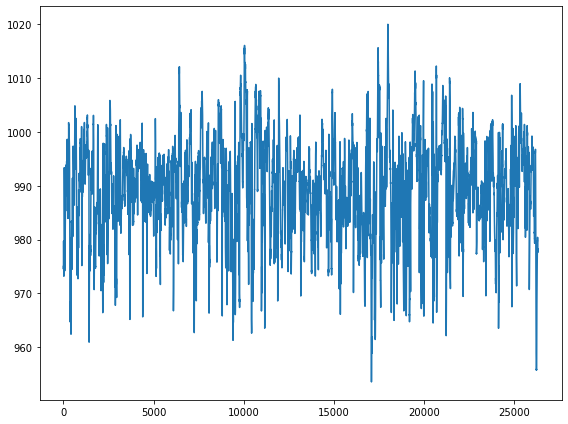

Temp_C statistics: count    26305.000000
mean        10.770512
std          8.196539
min        -13.330000
25%          4.250000
50%         10.220000
75%         16.740000
max         36.370000
Name: Temp_C, dtype: float64


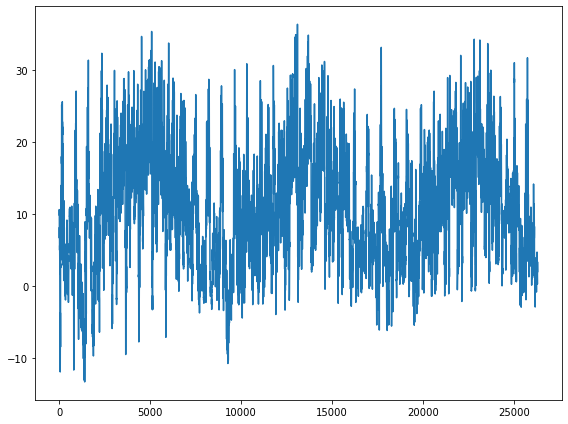

Temp_K statistics: count    26305.000000
mean       284.797449
std          8.293479
min        260.140000
25%        278.320000
50%        284.380000
75%        290.790000
max        310.800000
Name: Temp_K, dtype: float64


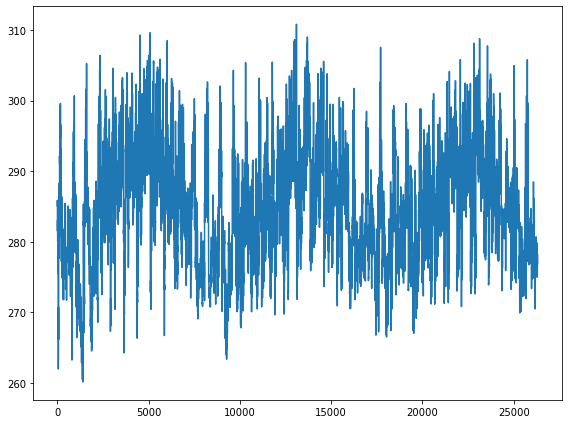

Temp_C_humi statistics: count    26305.000000
mean         5.327218
std          6.281108
min        -16.690000
25%          0.800000
50%          5.420000
75%         10.180000
max         20.070000
Name: Temp_C_humi, dtype: float64


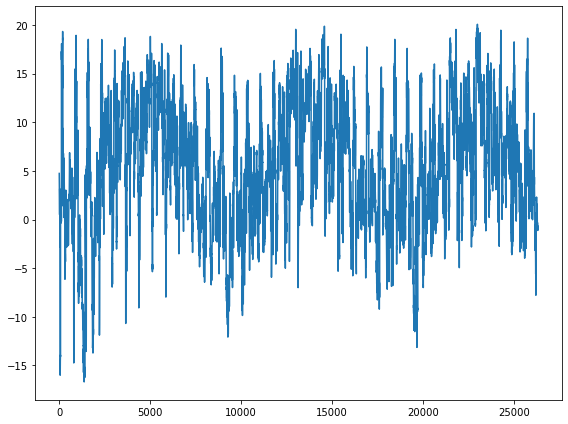

rel_humi% statistics: count    26305.000000
mean        72.102115
std         17.961947
min         18.180000
25%         59.550000
50%         75.030000
75%         86.380000
max        100.000000
Name: rel_humi%, dtype: float64


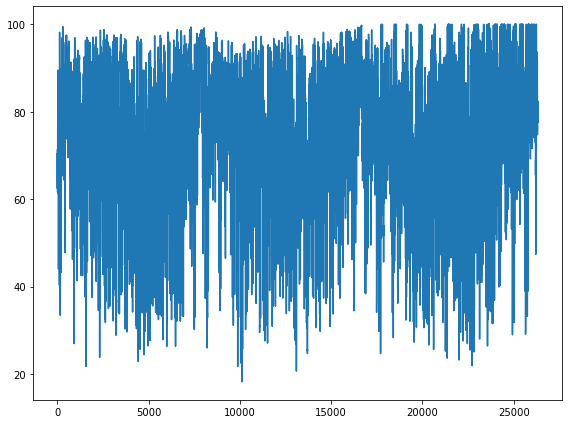

Vapor_p_max statistics: count    26305.000000
mean        14.740679
std          8.362219
min          2.180000
25%          8.280000
50%         12.480000
75%         19.100000
max         60.700000
Name: Vapor_p_max, dtype: float64


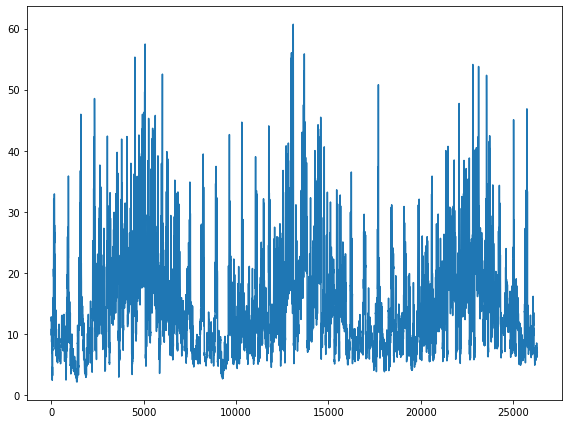

Vapor_p statistics: count    26305.000000
mean         9.680366
std          4.051777
min          1.640000
25%          6.480000
50%          8.990000
75%         12.440000
max         23.520000
Name: Vapor_p, dtype: float64


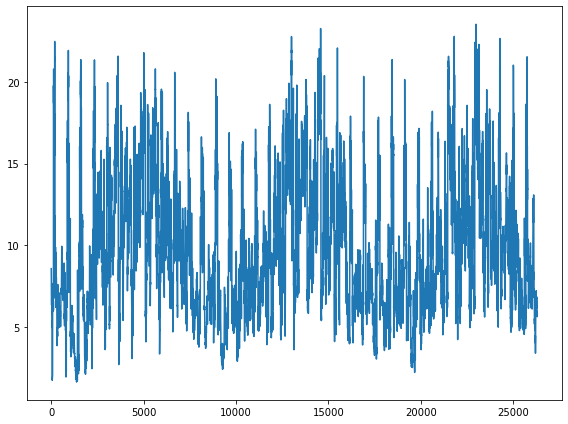

Vapor_p_deficit statistics: count    26305.000000
mean         5.060236
std          5.846931
min          0.000000
25%          1.230000
50%          2.740000
75%          6.730000
max         46.580000
Name: Vapor_p_deficit, dtype: float64


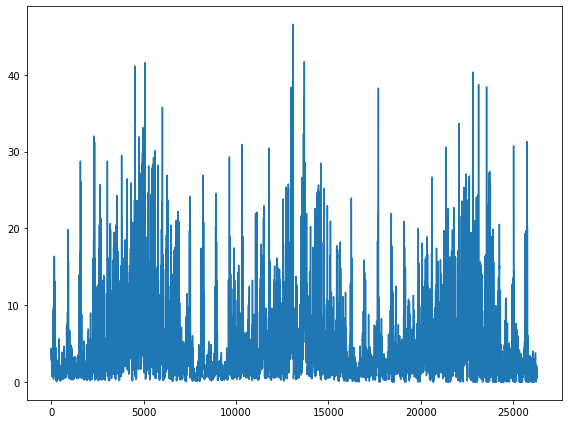

spe_humi statistics: count    26305.000000
mean         6.114892
std          2.573839
min          1.030000
25%          4.080000
50%          5.680000
75%          7.870000
max         14.930000
Name: spe_humi, dtype: float64


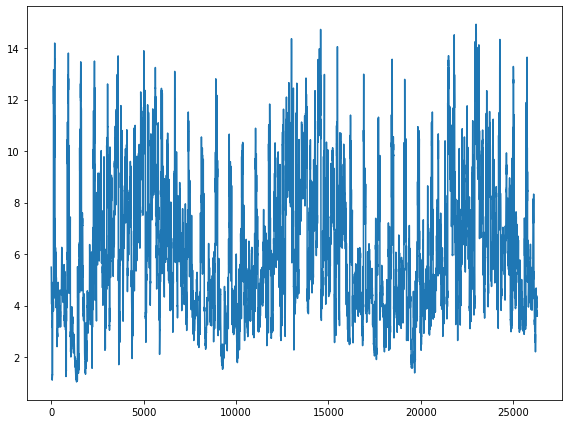

H2O_conc statistics: count    26305.000000
mean         9.788220
std          4.103747
min          1.650000
25%          6.550000
50%          9.100000
75%         12.600000
max         23.790000
Name: H2O_conc, dtype: float64


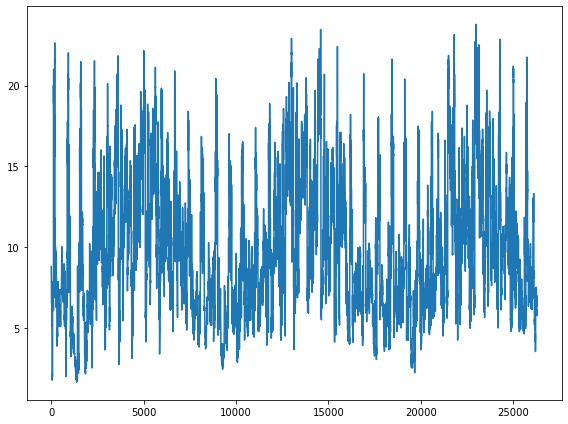

air_density statistics: count    26305.000000
mean      1210.552658
std         38.743197
min       1102.780000
25%       1182.010000
50%       1209.220000
75%       1238.380000
max       1334.180000
Name: air_density, dtype: float64


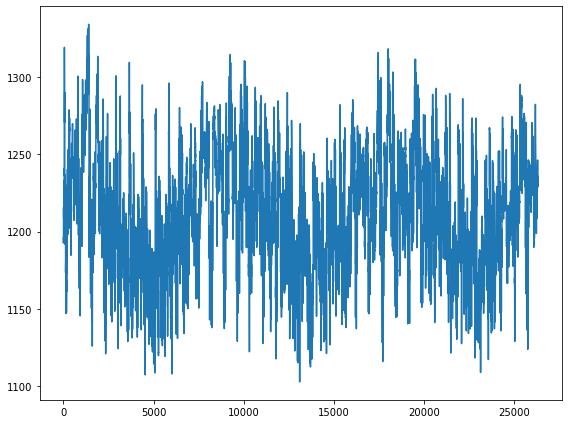

wind_sp statistics: count    26305.000000
mean         2.120814
std          1.502751
min          0.000000
25%          0.990000
50%          1.740000
75%          2.810000
max         13.210000
Name: wind_sp, dtype: float64


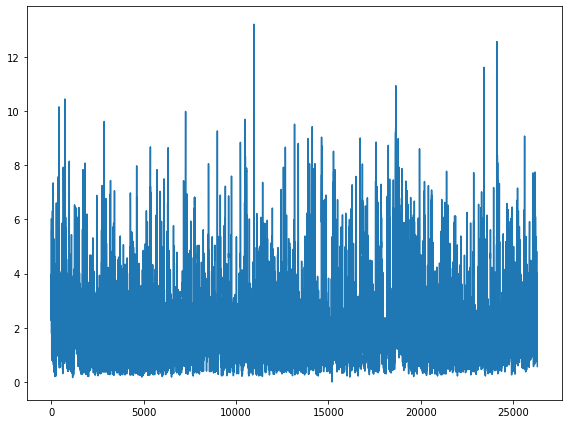

wind_sp_max statistics: count    26305.000000
mean         3.561045
std          2.318311
min          0.000000
25%          1.770000
50%          2.980000
75%          4.780000
max         19.670000
Name: wind_sp_max, dtype: float64


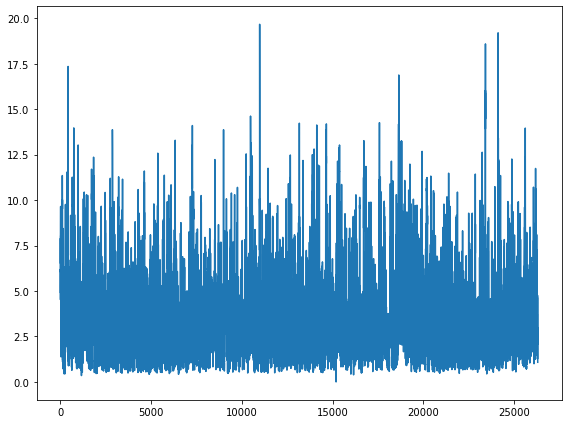

wind_direction statistics: count    26305.000000
mean       172.243054
std         70.715691
min          0.000000
25%        135.230000
50%        187.550000
75%        218.450000
max        357.100000
Name: wind_direction, dtype: float64


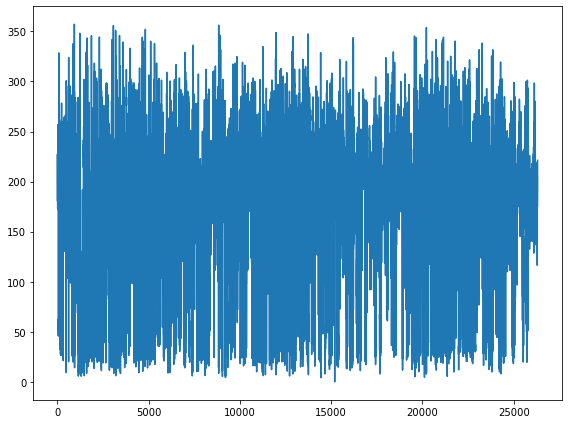

rain_depth statistics: count    26305.000000
mean         0.008136
std          0.068974
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.700000
Name: rain_depth, dtype: float64


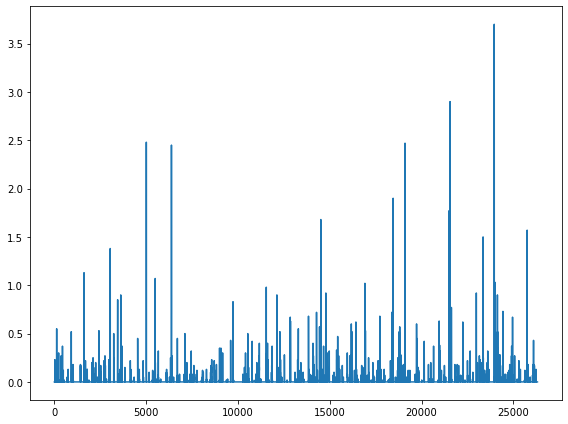

rain_time statistics: count    26305.000000
mean        26.630173
std        100.301710
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        600.000000
Name: rain_time, dtype: float64


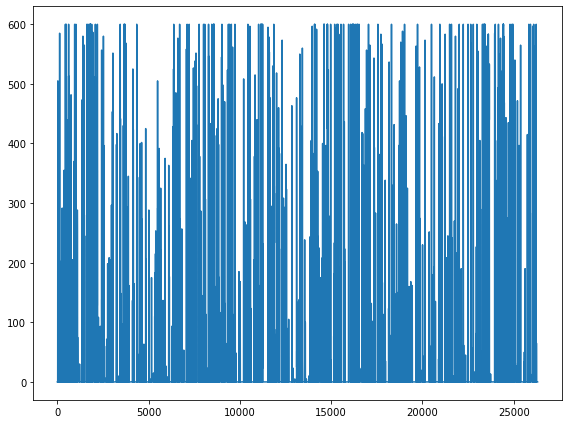

SWDR statistics: count    26305.000000
mean       131.993744
std        212.015442
min          0.000000
25%          0.000000
50%          5.050000
75%        188.900000
max        947.750000
Name: SWDR, dtype: float64


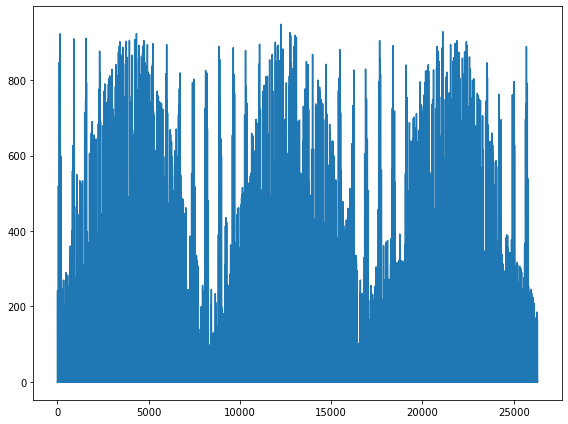

PAR statistics: count    26305.000000
mean       258.725779
std        412.091672
min          0.000000
25%          0.000000
50%         13.290000
75%        373.870000
max       1835.910000
Name: PAR, dtype: float64


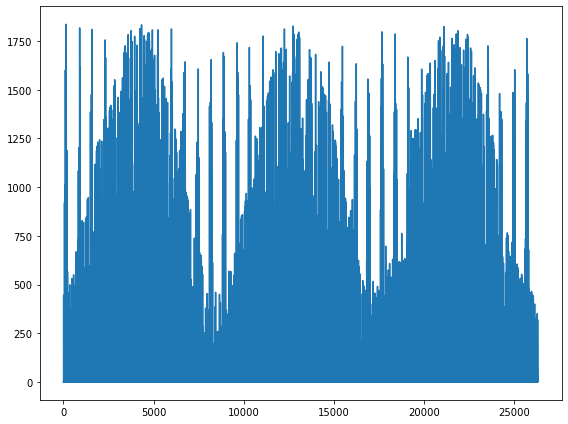

max_PAR statistics: count    26305.000000
mean       306.176979
std        495.897059
min      -6146.700000
25%          0.000000
50%         16.570000
75%        440.480000
max       2304.920000
Name: max_PAR, dtype: float64


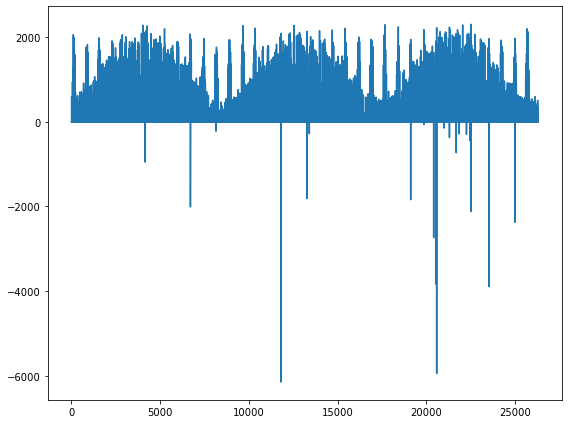

Tlog statistics: count    26305.000000
mean        21.689772
std          8.339062
min         -4.280000
25%         14.990000
50%         20.640000
75%         27.460000
max         49.020000
Name: Tlog, dtype: float64


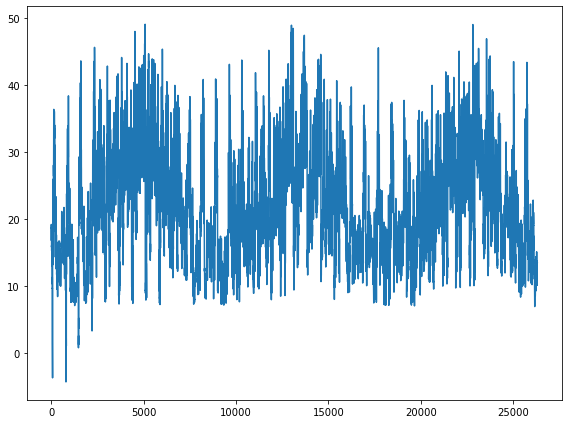

CO2 statistics: count    26305.000000
mean       403.967722
std        447.339440
min      -9999.000000
25%        412.420000
50%        421.050000
75%        433.920000
max        525.600000
Name: CO2, dtype: float64


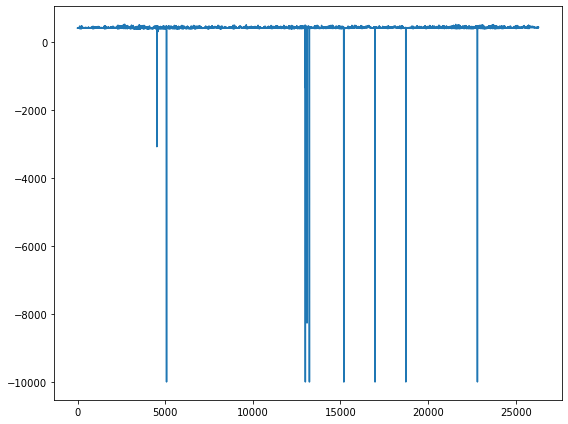

In [49]:
statistics_and_plt (df)

In [64]:
# change nagative CO2 to mean(after dropping nagative)
mean_CO2 = round(df[df["CO2"] >= 0]["CO2"].mean(),2)
df.loc[df["CO2"] < 0, "CO2"] = mean_CO2

new CO2 statistics: count    26305.000000
mean       424.849632
std         18.222568
min        311.880000
25%        412.530000
50%        421.130000
75%        433.920000
max        525.600000
Name: CO2, dtype: float64


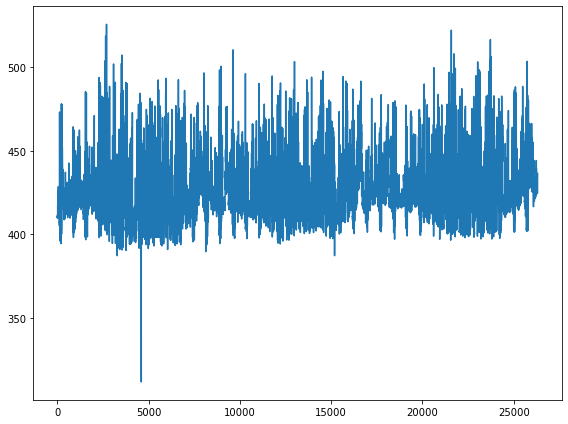

In [68]:
print(f"new CO2 statistics: {df['CO2'].describe()}")
plt.figure(figsize=(8, 6))
plt.plot(df["CO2"])
plt.tight_layout()
plt.show()